In [1]:
import keras
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

/Users/tyronemariano/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(143)

In [3]:
os.environ["KERAS_BACKEND"] = 'tensorflow'

In [4]:
SIZE = 256
batch_size = 16

In [5]:
from tensorflow.keras.regularizers import l2

# Increase filters gradually and reduce Dense layers
INPUT_SHAPE = (SIZE, SIZE, 3)

inp = keras.layers.Input(shape=INPUT_SHAPE)
# Start with fewer filters and increase
conv1 = keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
norm1 = keras.layers.BatchNormalization(axis=-1)(pool1)
drop1 = keras.layers.Dropout(rate=0.25)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
norm2 = keras.layers.BatchNormalization(axis=-1)(pool2)
drop2 = keras.layers.Dropout(rate=0.25)(norm2)

flat = keras.layers.Flatten()(drop2)

# Single Dense layer with fewer units
hidden1 = keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flat)
norm3 = keras.layers.BatchNormalization(axis=-1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.3)(norm3)

out = keras.layers.Dense(4, activation='softmax')(drop3)

In [6]:
model = keras.Model(inputs = inp, outputs = out)

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Add learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [8]:
# Use lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced from default 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,562,020 (128.03 MB)

 Trainable params: 33,561,412 (128.03 MB)

 Non-trainable params: 608 (2.38 KB)

None


In [10]:
#initialize datagen for train, test, validation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,        # Reduced from 10
    shear_range=0.1,        # Reduced from 0.2
    zoom_range=0.1,         # Reduced from 0.2
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [11]:
#create generator/iterator

train_generator = train_datagen.flow_from_directory(
    'archive/train',
    target_size = (SIZE, SIZE),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'archive/val',
    target_size = (SIZE, SIZE),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    'archive/test',
    target_size = (SIZE, SIZE),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [12]:
images, labels = next(train_generator)


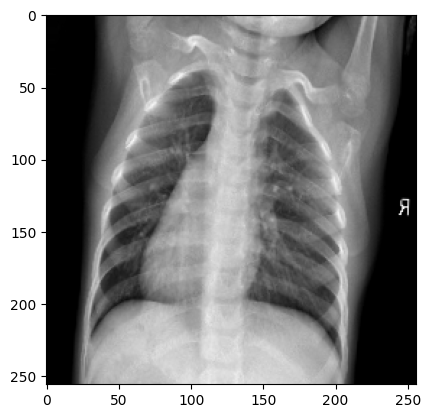

In [13]:
plt.imshow(images[0])

In [14]:
# from keras.callbacks import ModelCheckpoint

# filepath = "saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [cehckout]

In [15]:
# Add callback when training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)



Epoch 1/50


/Users/tyronemariano/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


396/396 ━━━━━━━━━━━━━━━━━━━━ 174s 434ms/step - accuracy: 0.7921 - loss: 5.3923 - val_accuracy: 0.4737 - val_loss: 4.9962 - learning_rate: 1.0000e-04
Epoch 2/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 201s 505ms/step - accuracy: 0.8742 - loss: 3.2058 - val_accuracy: 0.6316 - val_loss: 2.6944 - learning_rate: 1.0000e-04
Epoch 3/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 208s 520ms/step - accuracy: 0.8931 - loss: 2.0839 - val_accuracy: 0.5263 - val_loss: 3.3882 - learning_rate: 1.0000e-04
Epoch 4/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 204s 512ms/step - accuracy: 0.8933 - loss: 1.5642 - val_accuracy: 0.6579 - val_loss: 1.8746 - learning_rate: 1.0000e-04
Epoch 5/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 207s 517ms/step - accuracy: 0.8921 - loss: 1.3441 - val_accuracy: 0.6316 - val_loss: 2.0614 - learning_rate: 1.0000e-04
Epoch 6/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 219s 549ms/step - accuracy: 0.9110 - loss: 1.1635 - val_accuracy: 0.5000 - val_loss: 3.6007 - learning_rate: 1.0000e-04
Epoch 7/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 245s 616ms/

In [16]:
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.8239 - loss: 0.9092


In [17]:
print(f'Test Loss: {evaluation[0]:.4f}')
print(f'Test Accuracy: {evaluation[1]:.4f}')

Test Loss: 0.8195
Test Accuracy: 0.8542


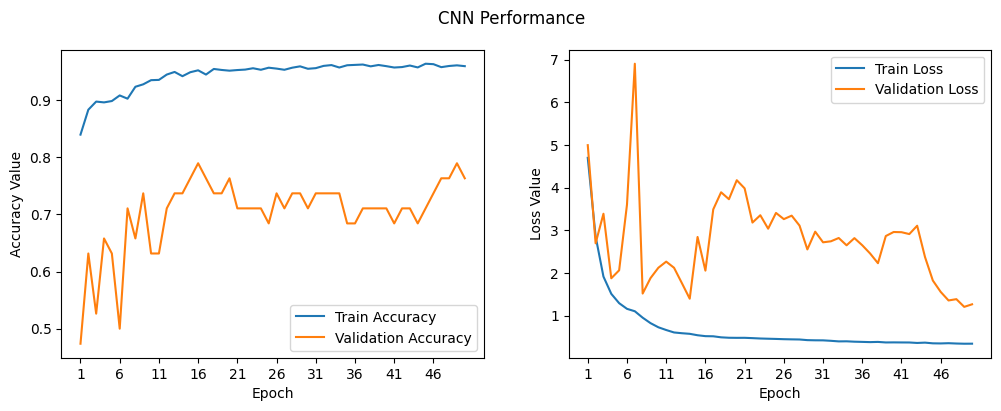

In [18]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
t = f.suptitle("CNN Performance")
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
l2 = ax2.legend(loc="best")

In [19]:
model.save(os.path.expanduser('~/Desktop/xray_cnn_test.h5'))

In [ ]:
########################

In [22]:
X_train = next(train_generator)

In [32]:
X_train

(array([[[[2.97541738e-01, 2.97541738e-01, 2.97541738e-01],
          [2.97326624e-01, 2.97326624e-01, 2.97326624e-01],
          [2.97111541e-01, 2.97111541e-01, 2.97111541e-01],
          ...,
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03]],
 
         [[2.87755877e-01, 2.87755877e-01, 2.87755877e-01],
          [2.88401216e-01, 2.88401216e-01, 2.88401216e-01],
          [2.89046526e-01, 2.89046526e-01, 2.89046526e-01],
          ...,
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03]],
 
         [[2.86274523e-01, 2.86274523e-01, 2.86274523e-01],
          [2.86274523e-01, 2.86274523e-01, 2.86274523e-01],
          [2.86274523e-01, 2.86274523e-01, 2.86274523e-01],
          ...,
          [7.84313772e-03, 7.84313772e-03, 7.8431

In [29]:
X_train[0][1].shape

(256, 256, 3)

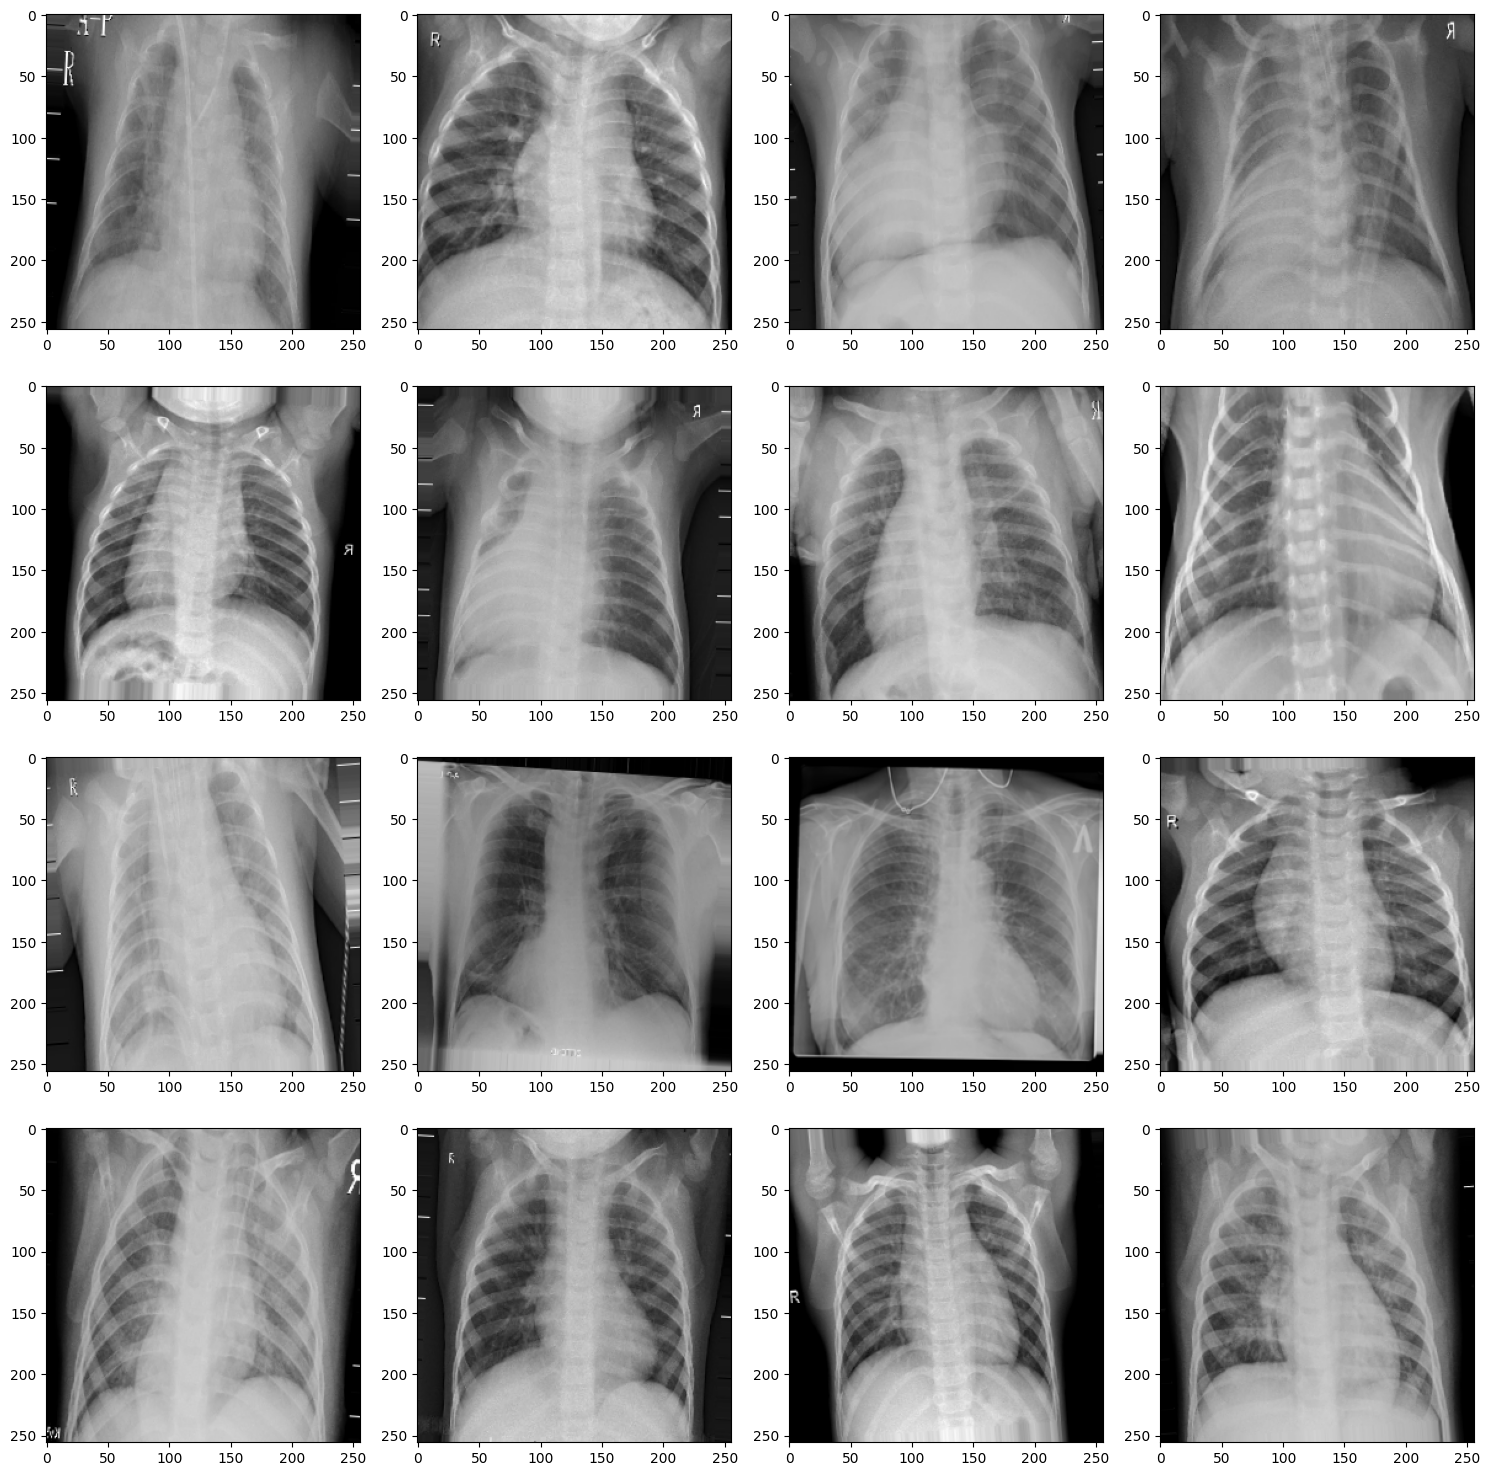

In [31]:
import cv2

plt.figure(figsize=(15, 15))

for i in range(16):
   plt.subplot(4, 4, i+1)
   rgb_image = cv2.cvtColor((X_train[0][i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
   plt.imshow(rgb_image)
   
   # Determine label based on one-hot encoded array
   # label = 'Malignant' if np.argmax(y_train[i]) == 1 else 'Benign'
   # plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()